# Gradient Boosting Classifier

ToDo's:
- Confusion Matrix
- Renaming of variables
- Nice print statements
- CNN model
- TF lite conversion

In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *
from sklearn.preprocessing import *
import pickle
import sys
import joblib
import os
import keras_tuner as kt

IMAGE_SIZE = [32, 32]

In [94]:
df = pd.read_json('../data/labelled_data/whole_data_1637521796.json', orient='records')

In [95]:
# Show amount of samples
print("amount of samples:", df.shape[0])
df.head(n=3)

amount of samples: 200


,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


## Binary Classification

### Data Preparation

In [96]:
# convert labels to binary
binary_label_converter = { 
    'Human': 1,
    'Several humans': 1, 
    'Non-human heat': 0, 
    'Ambigous heat': 0,
    'No heat':  0,
}


df_binary = df.copy()

df_binary['label'] = df['label'].apply(lambda x: binary_label_converter[x])
df_binary.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,0


In [97]:
# Prepare the data
y = df_binary['label'].to_numpy()
X = np.array(df_binary['data'].to_list())
X = np.expand_dims(X, axis=3)


print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [98]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(180, 32, 32, 1)
(180,)
(15, 32, 32, 1)
(15,)


### Feature Generation Model

In [99]:
# Squeezenet Model

# TODO: Use Baseline CNN model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)


model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
global_average_pooling2d_7 ( (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 66  

In [100]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


12/12 [==============================] - 1s 26ms/step - loss: 2.8057 - accuracy: 0.4667 - val_loss: 1.3969 - val_accuracy: 0.6000


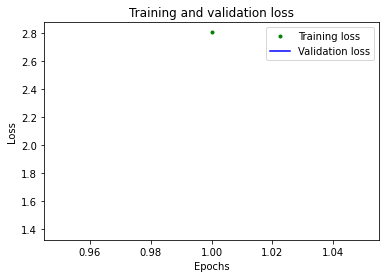

In [101]:
# Fit the model
EPOCHS = 1
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [102]:
def get_conv_layer_list(model):
    
    feature_map_list = []
        
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        # Get the layer input and output
        if i==0:
            inputs = model.inputs
        else:
            inputs = model.layers[i-1].input
            
        if i==len(model.layers):
            outputs = model.outputs
        else:
            outputs = model.layers[i].output
        
        current_feature_map = tf.keras.Model(name=layer.name, inputs=inputs, outputs=model.layers[i].output)
        feature_map_list.append(current_feature_map)
    
    return feature_map_list

In [103]:
# Define the custom layers

# Maximum layer
class MaxLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_max(inputs, axis=(1,2))
    
# Minimum layer
class MinLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_min(inputs, axis=(1,2))

# Mean layer
class MeanLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_mean(inputs, axis=(1,2))

In [104]:

def build_feature_extraction_model(model, conv_layer_list):

    # Build the model
    inputs = tf.keras.Input(shape=(32, 32, 1))

    max_layer = MaxLayer()
    min_layer = MinLayer()
    mean_layer = MeanLayer()
    concat_layer = tf.keras.layers.Concatenate(axis=-1)

    
    # TODO: Iterate over all convolutional layers
    
    conv_layer_output = conv_layer_list[0](inputs)
    max_fm = max_layer(conv_layer_output)
    min_fm = min_layer(conv_layer_output)
    mean_fm = mean_layer(conv_layer_output)
    
    concat = concat_layer([max_fm, min_fm, mean_fm])
   

    model = tf.keras.Model(name="whole_model", inputs=inputs, outputs=concat)
    
    return model

# Get the convolutional layers
conv_layer_list = get_conv_layer_list(model)

feature_extractor = build_feature_extraction_model(model, conv_layer_list)
feature_extractor.build(input_shape=(None, 32, 32, 1))
feature_extractor.summary()


pred = feature_extractor.predict(X)

print(pred.shape)


Model: "whole_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Functional)           (None, 32, 32, 32)   320         input_23[0][0]                   
__________________________________________________________________________________________________
max_layer_5 (MaxLayer)          (None, 32)           0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
min_layer_4 (MinLayer)          (None, 32)           0           conv2d_7[0][0]                   
________________________________________________________________________________________

In [105]:
# Save the model as tf lite model






In [106]:
layer_list = get_conv_layer_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"layer_binary_{i}")

INFO:tensorflow:Assets written to: layer_binary_0\assets


In [107]:
# Calculate the feature map mean
feature_map_list = []

im_mean = np.mean(X, axis=(1,2))
im_median = np.median(X, axis=(1,2))
im_std = np.std(X, axis=(1,2))
im_max = np.max(X, axis=(1,2))
im_min = np.min(X, axis=(1,2))
im_sum = np.sum(X, axis=(1,2))

feature_map_list.append(np.concatenate([im_mean,
                                           im_median,
                                           im_std,
                                           im_max,
                                           im_min,
                                           im_sum], axis=1))



# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_median = np.median(feature_map, axis=(1,2))
    feature_map_std = np.std(feature_map, axis=(1,2))
    feature_map_max = np.max(feature_map, axis=(1,2))
    feature_map_min = np.min(feature_map, axis=(1,2))
    feature_map_sum = np.sum(feature_map, axis=(1,2))
    feature_map_features = np.concatenate([feature_map_mean,
                                           feature_map_median,
                                           feature_map_std,
                                           feature_map_max, 
                                           feature_map_min, 
                                           feature_map_sum], axis=1)
    feature_map_list.append(feature_map_features)
    
feature_map_means = np.concatenate(feature_map_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

(200, 198)
[[1.37223633e+01 1.36000000e+01 1.41247853e+00 1.93000000e+01
  9.80000000e+00 1.40517000e+04 2.51012373e+00 0.00000000e+00
  1.09071052e+00 0.00000000e+00 0.00000000e+00 1.03623141e-02
  1.94362812e-02 3.78959322e+00 3.19896913e+00 2.95038819e-02
  1.04725909e+00 1.57708311e+00 3.23052835e+00 3.33182478e+00
  3.27573824e+00 5.70833497e-03 4.14300226e-02 1.46833301e+00
  1.97119322e-02 1.73773038e+00 7.46451915e-05 4.23998356e+00
  2.04276490e+00 1.55432463e+00 3.02789044e+00 0.00000000e+00
  1.54622743e-04 1.18222964e+00 1.08519650e+00 5.46894856e-02
  1.05935593e+01 6.00257015e+00 2.64385509e+00 0.00000000e+00
  1.08382249e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.83391666e+00 3.34996986e+00 0.00000000e+00
  1.02028537e+00 1.56183350e+00 3.34165525e+00 3.54788446e+00
  3.46477342e+00 0.00000000e+00 0.00000000e+00 1.52216065e+00
  0.00000000e+00 1.68409872e+00 0.00000000e+00 4.31965971e+00
  1.97272134e+00 1.57386208e+00 3.04942942e+00 0.00000000e+

In [108]:
df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), feature_map_means], axis=1))

In [109]:
df_train_binary_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1,13.722363,13.6,...,2091.79126,1591.628418,3100.559814,0.0,0.158334,1210.603149,1111.241211,56.002033,10847.804688,6146.631836
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1,13.538184,13.5,...,2048.463379,1572.918091,3045.038086,0.19653,0.10943,1181.938599,1116.8573,56.246773,10725.02832,6075.320801


In [110]:
# Prepare the data for gradient boosting
y_clf = df_train_binary_expanded[7].to_numpy().astype(int)
X_clf= df_train_binary_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 198)


In [111]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)
# X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_test_clf, y_test_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(180, 198)
(180,)
(20, 198)
(20,)
[0]


Accuracy Score: 0.75


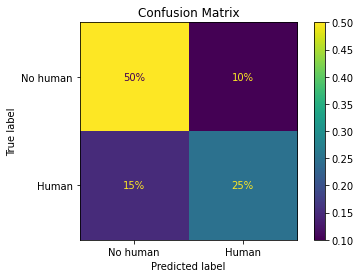

In [130]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
acc = clf.score(X_test_clf, y_test_clf)
print(f"Accuracy Score: {acc}")

# Calculate and display the confusion matrix
y_pred = clf.predict(X_test_clf)
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def calculate_conf_mat()

In [20]:
# Get the model size in kiB
def get_memory_size(clf, layer_list, fname = "clf_binary"):
    joblib.dump(clf, fname)
    model_size = os.path.getsize(fname)
    model_size = model_size / 1024
    print(f"GBT size in kiB: {model_size}")

    # Get the conv layers size in kiB
    layer_size = 0
    for i in range(len(layer_list)):
        layer_size = os.path.getsize(f"layer_binary_{i}")
    layer_size = layer_size / 1024
    print(f"Conv layer size in kiB: {layer_size}")

    # Total size for GBT in kiB
    print(f"Total size in kiB: {layer_size + model_size}")
    
get_memory_size(clf, layer_list)

GBT size in kiB: 326.30078125
Conv layer size in kiB: 4.0
Total size in kiB: 330.30078125


In [21]:
# HP-Tuning
NUM_FEATURES = 198

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 100)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 4)
    max_features = hp.Int("max_features", 1, NUM_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)


In [22]:
MAX_TRIALS = 40

# TODO: Use maybe other metrices!

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.balanced_accuracy_score),
    metrics=[skl.metrics.accuracy_score, balanced_accuracy_score],
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning_binary')



tuner.search(X_train_clf, y_train_clf)

best_model = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_model.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_model.get_params()}")

Trial 40 Complete [00h 00m 02s]
score: 0.6021760847847805

Best score So Far: 0.6393410936889198
Total elapsed time: 00h 03m 45s
INFO:tensorflow:Oracle triggered exit
Best model test score: 0.7
Best model params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1652361645376294, 'loss': 'deviance', 'max_depth': 7, 'max_features': 1, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 241, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.2, 'verbose': 0, 'warm_start': False}


In [23]:
get_memory_size(best_model, layer_list, fname="best_binary")

GBT size in kiB: 1557.0498046875
Conv layer size in kiB: 4.0
Total size in kiB: 1561.0498046875


In [24]:
# Compare predictions and ground truth

pred = best_model.predict(X_test_clf)

print(f"Ground Truth: {y_test_clf}")
print(f"Prediction:   {pred}")

Ground Truth: [1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0]
Prediction:   [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Multilabel Classification

In [87]:
df.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


In [88]:
# Convert labels
label_converter = { 
    'Human': 0,
    'Several humans': 1, 
    'Non-human heat': 2, 
    'Ambigous heat': 3,
    'No heat':  4
}

df['label'] = df['label'].apply(lambda x: label_converter[x])
df.head(n=100)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,0
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,0
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,3
3030,3030,2021-05-07 13:10:30,3078,22.400000,-73,"[[10.9, 11.1, 11.2, 10.8, 12.0, 12.2, 12.7, 12...",True,1
1427,1427,2021-05-07 13:07:54,3078,21.799999,-82,"[[10.8, 10.9, 10.7, 10.7, 11.7, 11.4, 11.2, 10...",True,2
...,...,...,...,...,...,...,...,...
9911,9911,2021-05-07 13:13:12,C088,23.100000,-72,"[[10.6, 10.9, 12.0, 12.3, 13.5, 12.4, 12.8, 12...",True,2
4612,4612,2021-05-07 13:13:06,3078,23.100000,-78,"[[10.7, 12.1, 12.1, 11.4, 11.6, 11.3, 12.3, 12...",True,2
5300,5300,2021-05-07 13:06:01,C088,21.200001,-66,"[[11.5, 13.0, 12.4, 12.1, 13.0, 13.1, 12.6, 12...",True,3
5603,5603,2021-05-07 13:06:30,C088,21.299999,-63,"[[12.0, 11.8, 12.6, 12.6, 13.3, 12.9, 13.6, 13...",True,3


In [96]:
# Prepare the data
y = df['label'].to_numpy()
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(y)+1))
y_onehot = label_binarizer.transform(y)

X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y_onehot.shape)
print(y_onehot[:1])
assert np.all(np.sum(y_onehot, axis=1) == 1)
print(X.shape)

(200, 5)
[[1 0 0 0 0]]
(200, 32, 32, 1)


In [97]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train[:1])

(180, 32, 32, 1)
(180, 5)
(15, 32, 32, 1)
(15, 5)
[[0 0 0 0 1]]


In [98]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(5, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [100]:
model.compile(
optimizer='adam',
loss= 'categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 5))
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 165 

Epoch 1/30
12/12 [==============================] - 1s 29ms/step - loss: 2.4561 - accuracy: 0.3333 - val_loss: 1.4148 - val_accuracy: 0.3333
Epoch 2/30
12/12 [==============================] - 0s 18ms/step - loss: 1.5652 - accuracy: 0.3833 - val_loss: 1.2626 - val_accuracy: 0.3333
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 1.5315 - accuracy: 0.3389 - val_loss: 1.3155 - val_accuracy: 0.3333
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 1.4622 - accuracy: 0.3500 - val_loss: 1.2817 - val_accuracy: 0.3333
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 1.4646 - accuracy: 0.3333 - val_loss: 1.3398 - val_accuracy: 0.3333
Epoch 6/30
12/12 [==============================] - 0s 10ms/step - loss: 1.4442 - accuracy: 0.3833 - val_loss: 1.3104 - val_accuracy: 0.3333
Epoch 7/30
12/12 [==============================] - 0s 10ms/step - loss: 1.4452 - accuracy: 0.4000 - val_loss: 1.3342 - val_accuracy: 0.3333
Epoch 8/30
12

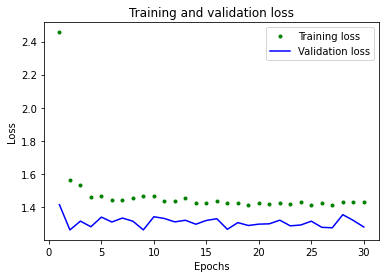

In [101]:
# Fit the model
EPOCHS = 30
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [102]:
layer_list = get_feature_map_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"layer_{i}")

1 conv2d_4 (None, 32, 32, 32)
INFO:tensorflow:Assets written to: layer_0\assets


In [103]:
# Calculate the feature map mean
feature_map_list = []

im_mean = np.mean(X, axis=(1,2))
im_median = np.median(X, axis=(1,2))
im_std = np.std(X, axis=(1,2))
im_max = np.max(X, axis=(1,2))
im_min = np.min(X, axis=(1,2))
im_sum = np.sum(X, axis=(1,2))

feature_map_list.append(np.concatenate([im_mean,
                                           im_median,
                                           im_std,
                                           im_max,
                                           im_min,
                                           im_sum], axis=1))



# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_median = np.median(feature_map, axis=(1,2))
    feature_map_std = np.std(feature_map, axis=(1,2))
    feature_map_max = np.max(feature_map, axis=(1,2))
    feature_map_min = np.min(feature_map, axis=(1,2))
    feature_map_sum = np.sum(feature_map, axis=(1,2))
    feature_map_features = np.concatenate([feature_map_mean,
                                           feature_map_median,
                                           feature_map_std,
                                           feature_map_max, 
                                           feature_map_min, 
                                           feature_map_sum], axis=1)
    feature_map_list.append(feature_map_features)
    
feature_map_means = np.concatenate(feature_map_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

(200, 198)
[[1.37223633e+01 1.36000000e+01 1.41247853e+00 1.93000000e+01
  9.80000000e+00 1.40517000e+04 7.15011656e-01 0.00000000e+00
  0.00000000e+00 1.49491891e-01 8.17718327e-01 0.00000000e+00
  4.40455824e-01 0.00000000e+00 1.00603444e-03 1.66070892e-03
  3.48639518e-01 6.61285102e-01 2.87988130e-02 0.00000000e+00
  1.18140161e+00 2.82847486e-03 5.15798405e-02 7.84609318e-01
  9.37332064e-02 2.28866818e-03 7.34356642e-02 0.00000000e+00
  7.14292973e-02 4.15567163e-04 0.00000000e+00 5.53556625e-03
  4.53765281e-02 9.10370886e-01 0.00000000e+00 1.90507658e-02
  0.00000000e+00 8.52914825e-02 5.91847599e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.27529311e-01 0.00000000e+00
  4.57392097e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.88592100e-01 6.38815343e-01 0.00000000e+00 0.00000000e+00
  1.16766357e+00 0.00000000e+00 0.00000000e+00 7.49710917e-01
  2.33299397e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+

In [104]:
df_train_expanded = pd.DataFrame(np.concatenate([df.head(X.shape[0]), feature_map_means], axis=1))

In [105]:
# Prepare the data for gradient boosting
y_clf = df_train_expanded[7].to_numpy().astype(int)
X_clf= df_train_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 198)


In [107]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)
# X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_test_clf, y_test_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(180, 198)
(180,)
(20, 198)
(20,)
[4]


In [108]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
clf.score(X_test_clf, y_test_clf)# Train the GBT

0.4

In [109]:
# HP-Tuning
NUM_FEATURES = 198

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 300)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 8)
    max_features = hp.Int("max_features", 1, NUM_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)

In [110]:
MAX_TRIALS = 40

# TODO: Use maybe other metrices!

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.balanced_accuracy_score),
    metrics=[skl.metrics.accuracy_score, balanced_accuracy_score],
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning')



tuner.search(X_train_clf, y_train_clf)

best_model = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_model.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_model.get_params()}")

Trial 41 Complete [00h 00m 15s]
score: 0.2891082251082251

Best score So Far: 0.3476017316017316
Total elapsed time: 00h 10m 55s
INFO:tensorflow:Oracle triggered exit
Best model test score: 0.35
Best model params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.6356198890804754, 'loss': 'deviance', 'max_depth': 2, 'max_features': 144, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 203, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.2, 'verbose': 0, 'warm_start': False}


In [111]:
get_memory_size(best_model, layer_list, fname="best")

GBT size in kiB: 930.3837890625
Conv layer size in kiB: 4.0
Total size in kiB: 934.3837890625


In [112]:
# Compare predictions and ground truth
pred = best_model.predict(X_test_clf)

print(f"Ground Truth: {y_test_clf}")
print(f"Prediction:   {pred}")

Ground Truth: [0 2 3 3 0 0 2 3 0 2 2 3 2 0 2 0 0 2 0 3]
Prediction:   [2 0 2 2 3 0 2 2 0 0 2 2 2 0 2 2 2 0 2 0]
